In [18]:
%matplotlib ipympl
from impedance.preprocessing import readBioLogic
from impedance.models.circuits import CustomCircuit
import matplotlib.pyplot as plt
import numpy as np
from models import *
import mpmath as mp
import os
import csv

In [19]:
@element(num_params=6, units=["Ohm", "Ohm F", "Ohm F","","",""],overwrite=True)
def TLMtwoQvary(p,f):
   
    omega = 2 * np.pi * np.array(f)
    R1,R1R2, R1Q1, R1Q2, delta1, alpha = p[0], p[1], p[2], p[3], p[4], p[5]
    delta2=1-delta1
    R2=R1R2/R1
    R2Q2=R1Q2/R1*R2
    k12=R2/R1
    wc1=1/(R1Q1)
    wc2=1/(R2Q2)
    S1=np.sqrt((omega*1j)**alpha/wc1)
    S2=np.sqrt((omega*1j)**alpha/wc2)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)

    Z=2*(R1)*(C1*C2*S1*k12+S2)/(S1*(C2*S1*k12+C1*S2))

    return Z

In [ ]:
folder_path=os.path.join("..","exp data","EIS mpt files","two combined")
first_itr=True
for file_name in os.listdir(folder_path):
    file_path=os.path.join(folder_path,file_name)
    f,z=readBioLogic(file_path)
    
    Rsep=100
    R1=2000
    R2=5000
    Q1=1e-4
    Q2=3e-4
    delta=0.18
    alpha=1
    c=CustomCircuit(initial_guess=[Rsep,R1,R1*R2,R1*Q1,R2*Q2,delta,alpha],circuit="R_1-TLMtwoQvary")

    mp.dps=500
    c.fit(impedance=z,frequencies=f,bounds=((0,0,0,0,0,0.167,0.9),(np.inf,np.inf,np.inf,np.inf,np.inf,0.6,1)))
    
    z_fitted=c.predict(frequencies=f)
    fcsv="../fitted parameters/two combined.csv"
    if first_itr:
        data=[
            ["filename","Rsep","R1","R1R2","R1Q1","R2Q2","delta","α"],
            [f"{file_name}",c.parameters_[0],c.parameters_[1],c.parameters_[2],c.parameters_[3],c.parameters_[4],c.parameters_[5],c.parameters_[6]]
        ]
        first_itr=False
        with open(fcsv,"w",newline="",encoding='UTF-8') as csv_file:
            writer=csv.writer(csv_file)
            writer.writerows(data)
    else:
        data=[
            [f"{file_name}",c.parameters_[0],c.parameters_[1],c.parameters_[2],c.parameters_[3],c.parameters_[4],c.parameters_[5],c.parameters_[6]]
        ]
        with open(fcsv,"a",newline="",encoding='UTF-8') as csv_file:
            writer=csv.writer(csv_file)
            writer.writerows(data)

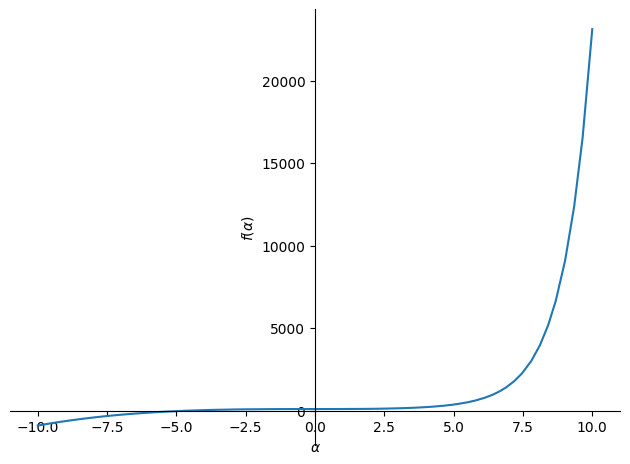

In [41]:
from sympy import *
import numpy
a=symbols("α")
series(exp(a))
eq1=a**3+sin(a**2)+exp(a)+100
nsolve(eq1,8)
plot(eq1)